In [97]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split

import pandas as pd, mysql.connector, nltk
import xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation

In [31]:
# get the first file which has product titles and brand categoriws
df1 = pd.read_csv('\\Users\\Dan\\Documents\\Python\\Data\\Flix_products\\product_title.csv', engine='python')
df1.head(2)

,product_id,title,Categories
0,400002,HP Photosmart eStation Printer,Printers and Multifunction | Inkjet All-in-One...
1,400004,HP LaserJet Pro M1217nfw Multifunction Printer,Printers and Multifunction | Laser Multifuncti...


In [30]:
# load second product file and load only the necessary columns
products_complete = pd.read_csv('\\Users\\Dan\\Documents\\Python\\Data\\Flix_products\\products.csv', sep='\t')
products= products_complete[['product_id','product_title','mpn_list','manufacturer_id', 'brand_title',
                            'flix_parent_category', 'flix_subCategory1', 'flix_subCategory2',
                            'benchmark_category', 'benchmark_category2']]
products.head(2)

C:\Users\Dan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,product_id,product_title,mpn_list,manufacturer_id,brand_title,flix_parent_category,flix_subCategory1,flix_subCategory2,benchmark_category,benchmark_category2
0,3,Crematic Coffee Maker,F8744338,53.0,Groupe SEB,Small Gadgets/Appliances,Drink Makers,Coffee/Espresso,Home Appliances,Drink Makers
1,4,Vitamin Plus 3-Tier Steamer,vc400415,4.0,Tefal,Small Gadgets/Appliances,Cooking,Steamers,Home Appliances,Steamers


In [79]:
# merge the two products file with an inner join to keep only the common products from both
products = pd.merge(products, df1, on='product_id', how='inner')
products.head(2)

,product_id,product_title,mpn_list,manufacturer_id,brand_title,flix_parent_category,flix_subCategory1,flix_subCategory2,benchmark_category,benchmark_category2,title,Categories
0,881868,HP EliteBook 840 G1 Notebook PC,J8Q77EA,28.0,HP,Computing/Gaming,Laptops/Notebook/Ebook/Ultrabook,Notebooks,Computing,Laptops,HP EliteBook 840 G1 Notebook PC,Laptops And Hybrids | Business Laptop PCs | HP...
1,876236,Speedlight SB-N7,FSA90901,1290.0,Nikon,Cameras,Camera Accessories,None,Cameras,Cameras Accessories,Speedlight SB-N7,Speedlights


In [80]:
# check how many products have unassigned categories
products['benchmark_category2'].isna().sum(), products['benchmark_category2'].isna().sum()/len(products.index)

(3665, 0.05178455364964535)

In [81]:
# drop the unassugned category products
products.dropna(subset=['benchmark_category2'], inplace=True)

Text(0.5, 0, '# of products')

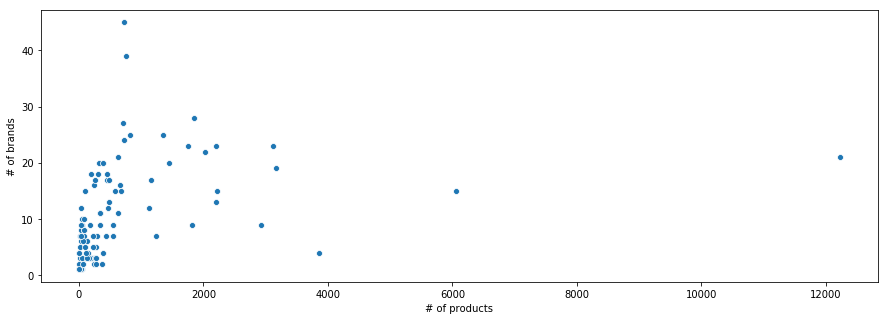

In [106]:
# let's look at the distribution of number of products and brands by product categories
group_products = products.groupby('benchmark_category2')['product_id'].count()
group_brand  = products.groupby('benchmark_category2')['brand_title'].nunique()
plt.figure(figsize=(15,5))
ax = sns.scatterplot(x=group_products, y=group_brand)
ax.set_ylabel('# of brands')
ax.set_xlabel('# of products')

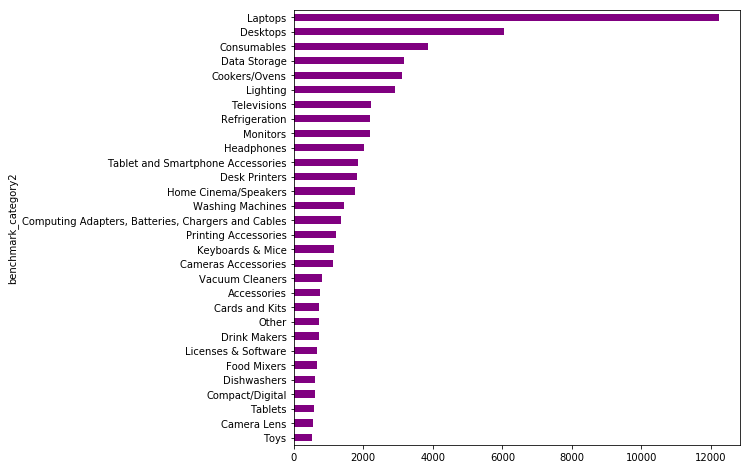

In [109]:
# lets look at the top 30 categories by number of products
products.groupby('benchmark_category2')['product_id'].count().sort_values().tail(30).plot.barh(figsize=(8,8), color='purple')

In [110]:
# lets subset by top 15 categories and use this data for further analysis
top15cats = products.groupby('benchmark_category2')['product_id'].count().nlargest(15).keys()
prod_15cats = products[products['benchmark_category2'].isin(top15cats)].reset_index()
prod_15cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48227 entries, 0 to 48226
Data columns (total 13 columns):
index                   48227 non-null int64
product_id              48227 non-null int64
product_title           47698 non-null object
mpn_list                47976 non-null object
manufacturer_id         48227 non-null float64
brand_title             48227 non-null object
flix_parent_category    48227 non-null object
flix_subCategory1       48227 non-null object
flix_subCategory2       40661 non-null object
benchmark_category      48227 non-null object
benchmark_category2     48227 non-null object
title                   48227 non-null object
Categories              48227 non-null object
dtypes: float64(1), int64(2), object(10)
memory usage: 4.8+ MB


# 2. Categorisation with product titles and categories

In [111]:
prod_15cats['Categories'].head(2)

0    Laptops And Hybrids | Business Laptop PCs | HP...
1                   Electrolux | NonStar | Cooker_Hood
Name: Categories, dtype: object

In [112]:
# Remove the pipes '|' in the Categories
prod_15cats['Categories'] = prod_15cats['Categories'].str.replace('|', '')
prod_15cats['Categories'].head(2)

0    Laptops And Hybrids  Business Laptop PCs  HP E...
1                     Electrolux  NonStar  Cooker_Hood
Name: Categories, dtype: object

In [ ]:
# lets concatenate the two columns : product titles and categories
prod_15cats['title&cat']=np.nan
for i in range(len(prod_15cats)):
    if pd.isna(prod_15cats.loc[i, 'product_title']):
        prod_15cats.loc[i, 'title&cat'] =  prod_15cats.loc[i, 'title'] + ' ' + prod_15cats.loc[i, 'Categories']
    else:
        prod_15cats.loc[i,'title&cat'] =  prod_15cats.loc[i, 'product_title'] + ' ' + prod_15cats.loc[i, 'Categories']

In [ ]:
# check for empty strings in the two columns 
#prod_15cats[prod_15cats[['product_title','Categories']].isnull().values.any(1)]

In [144]:
prod_15cats.head(2)

,index,product_id,product_title,mpn_list,manufacturer_id,brand_title,flix_parent_category,flix_subCategory1,flix_subCategory2,benchmark_category,title,Categories,title&cat
0,0,881868,HP EliteBook 840 G1 Notebook PC,J8Q77EA,28.0,HP,Computing/Gaming,Laptops/Notebook/Ebook/Ultrabook,Notebooks,Computing,HP EliteBook 840 G1 Notebook PC,Laptops And Hybrids Business Laptop PCs HP E...,HP EliteBook 840 G1 Notebook PCLaptops And Hyb...
1,2,888696,Electrolux EFC60465OX Chimney Design Hood 60 c...,EFC60465OX,1307.0,Electrolux Major,Home Appliances,Cooker Hoods,None,Home Appliances,Electrolux EFC60465OX Chimney Design Hood 60 c...,Electrolux NonStar Cooker_Hood,Electrolux EFC60465OX Chimney Design Hood 60 c...


In [116]:
# create train and test set with stratified sampling
y = prod_15cats.pop('benchmark_category2')
X = prod_15cats[['product_id','title&cat']]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42, stratify=y)

In [118]:
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)
count_train = count_vec.fit(prod_15cats['title&cat'])
bag_of_words = count_vec.transform(prod_15cats['title&cat'])

ValueError: np.nan is an invalid document, expected byte or unicode string.